**Project Overview**

This project develops machine learning models (Logistic Regression, Decision Tree, and Random Forest) to predict earthquake damage levels in buildings affected by the 2015 earthquakes in Kavrepalanchok, Nepal. 

Using building characteristics and structural features, the models classify damage into three categories: low damage (Grade 1), medium damage (Grade 2), and near-complete destruction (Grade 3).

**Potential Real-World Impact**

Earthquake damage prediction models serve critical functions in disaster management and urban planning :

- Disaster Preparedness: Enable rapid damage assessment for emergency response allocation
- Risk Assessment: Identify vulnerable building types for preventive interventions
- Insurance Applications: Support actuarial modeling for earthquake insurance policies
- Urban Planning: Guide building code improvements and construction standards
- Reconstruction Planning: Prioritize rebuilding efforts based on predicted damage patterns



# 010: Prepare 

Steps: 
1. Import libraries
2. Load dataset
3. Data quality assessment - to note xtics and structure of the dataframe
4. Data Cleaning 

**1. Import Libraries**

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# set styles
sns.set_style("whitegrid")  # or "darkgrid", "white", "ticks", "dark"
sns.set_palette("pastel")   # or try "husl", "rocket", "mako", "coolwarm", etc.



from category_encoders import OneHotEncoder 
from category_encoders import OrdinalEncoder 

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline 

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score,  make_scorer
import time
import joblib


**2. Load Dataset**

In [2]:
df = pd.read_csv("/workspaces/Earthquake-Damage-Classification-Kavrepalanchok-Nepal/data/kavrepalanchok_raw.csv")

# df.head()
df.info()
                 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76533 entries, 0 to 76532
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   b_id                    76533 non-null  int64 
 1   building_id             76533 non-null  int64 
 2   count_floors_pre_eq     76533 non-null  int64 
 3   count_floors_post_eq    76533 non-null  int64 
 4   age_building            76533 non-null  int64 
 5   plinth_area_sq_ft       76533 non-null  int64 
 6   height_ft_pre_eq        76533 non-null  int64 
 7   height_ft_post_eq       76533 non-null  int64 
 8   land_surface_condition  76533 non-null  object
 9   foundation_type         76533 non-null  object
 10  roof_type               76533 non-null  object
 11  ground_floor_type       76533 non-null  object
 12  other_floor_type        76533 non-null  object
 13  position                76533 non-null  object
 14  plan_configuration      76533 non-null  object
 15  co

**3. Data Quality Assessment**

In [3]:
# df.head()

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

# Examine categorical variables
uniq_val_col = df.columns
for col in uniq_val_col:
    print(f"\n{col} unique values: {df[col].nunique()}")
    print(df[col].value_counts().head())


Missing values per column:
b_id                      0
building_id               0
count_floors_pre_eq       0
count_floors_post_eq      0
age_building              0
plinth_area_sq_ft         0
height_ft_pre_eq          0
height_ft_post_eq         0
land_surface_condition    0
foundation_type           0
roof_type                 0
ground_floor_type         0
other_floor_type          0
position                  0
plan_configuration        0
condition_post_eq         0
superstructure            0
damage_grade              0
dtype: int64

b_id unique values: 76533
b_id
87473    1
87479    1
87482    1
87491    1
87496    1
Name: count, dtype: int64

building_id unique values: 76533
building_id
87473    1
87479    1
87482    1
87491    1
87496    1
Name: count, dtype: int64

count_floors_pre_eq unique values: 9
count_floors_pre_eq
2    50298
3    16783
1     6767
4     2004
5      590
Name: count, dtype: int64

count_floors_post_eq unique values: 9
count_floors_post_eq
2    33998
0    1

Key characteristics to note about our dataframe, df: 
1. Our target variable (`damage_grade` column) has 5 unique values, Grade 1,2,3,4,5. 
2. Also, our goal is to differentite these five Grades by getting entries with `severe_damage` above 3 and those below as separate data points. 
4. We have post earthquake data (ending in "...post_eq"). These are leaky columns - to be dropped when cleaning.
5. `building_id` is the key column, rep. all the Nepal buildings damaged in 2015 during earthquakes. Since we don't need the exact number of each building, we will turn this column into the index for easier readability and lookup. Also `b_id` is same as `building_id` so we will drop it. 

**4. Data Cleaning**

Steps: 
- make `building_id` as index and drop `b_id`
- drop leaky columns
- create our binary target `severe_damage` column - with two classes, Class 1 and Class 0 for each building, where buildings with `damage_grade` greater than 3, i.e. severe damage, are encoded at Class 1 while all other buildings with less severe damage are endoded at Class 0.
- Correlation Matrix (heatmap) - to find columns with strong correlation with `severe_damage`  correlation and drop then to avoid redundant columns offering same classification power i.e. Reduce complexity and increaseefficiency.


In [4]:
# make building_id as index 
        # df_clean = df.drop(columns="building_id", inplace=True)  # allows for df.loc[index] 

df_clean = df.set_index("building_id", drop=True)   # allows df.loc[building_id],more convinient than df.loc[index]

# drop "b_id"
df_clean = df_clean.drop(columns = "b_id")


df_clean.head()

,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
building_id,,,,,,,,,,,,,,,,
87473,2,1,15,382,18,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 4
87479,1,0,12,328,7,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5
87482,2,1,23,427,20,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87491,2,1,12,427,14,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
87496,2,0,32,360,18,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5


In [5]:
# Drop leaky columns - leaky columns are columns that have post-earthquake data, i.e. any column ending in '..._post_eq'
#                      the goal is to predict earthquake damage, having columns with already recorded post_eq data is 
#                      basically cheating. 

            # drop_cols = []
            
            # for col in df_clean.columns: 
            #     if "post_eq" in col: 
            #         drop_cols.append(col)
            
            # drop_cols 

# Make simple into a list comprehension (Pythonic way of expressing the same logic in a single expression) 

drop_cols = [col for col in df_clean.columns if "post_eq" in col]

df_clean.drop(columns=drop_cols, inplace=True)

# df_clean.info()



In [6]:
# create our binary target `severe_damage` column 

df_clean["damage_grade"] = df_clean["damage_grade"].str[-1].astype(int)   #grabs last character i.e. 1,2,3,4,5 leaving Grade
df_clean["severe_damage"] = (df_clean["damage_grade"] > 3).astype(int)     # if 4 or 5, encode as 1s, else as 0s

# Then drop the redundant 'damage_grade'

df_clean = df_clean.drop(columns="damage_grade")

# df_clean.info()

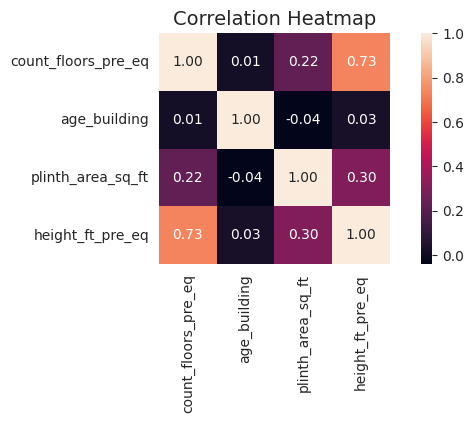

In [7]:
# Correlation Matrix (heatmap) - to find columns with strong correlation with severe_damage

# Select only the relevant columns
correlation = df[["count_floors_pre_eq", "age_building", "plinth_area_sq_ft", "height_ft_pre_eq"]].corr()

# Plot correlation matrix as a heatmap with values 
plt.figure(figsize=(8,3))
sns.heatmap(
    correlation,
    annot=True,        # put the correlation values inside cells
    fmt=".2f",         # format as float with 2 decimal places
    cmap="rocket",   # nice diverging colormap
    cbar=True,         # show the color bar
    square=True        # make cells square
)
plt.title("Correlation Heatmap", fontsize=14)
plt.show() 

In [8]:
# We can see that `count_floors_pre_eq` is strongly correlated with `height_ft_pre_eq`. They both offer similar or ar 
# least close enough predictive power. Keeing the two is redundant. We fix this by dropping `count_floors_pre_sq`. 

# We keep `height_ft_pre_eq` because its values are continuous (a wide range of independent heights) while 
#`count_floors_pre_eq` is discrete (values=[1, 0, 2, 3, 4, 9, 5, 6, 8, 7]) and loses some detail if used in classification

df_clean.drop(columns="count_floors_pre_eq", inplace=True)


df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76533 entries, 87473 to 163998
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            76533 non-null  int64 
 1   plinth_area_sq_ft       76533 non-null  int64 
 2   height_ft_pre_eq        76533 non-null  int64 
 3   land_surface_condition  76533 non-null  object
 4   foundation_type         76533 non-null  object
 5   roof_type               76533 non-null  object
 6   ground_floor_type       76533 non-null  object
 7   other_floor_type        76533 non-null  object
 8   position                76533 non-null  object
 9   plan_configuration      76533 non-null  object
 10  superstructure          76533 non-null  object
 11  severe_damage           76533 non-null  int64 
dtypes: int64(4), object(8)
memory usage: 7.6+ MB


# 020: Explore 


The goal here with Exploratory Data Analysis (EDA) is to see the characteristics of the data we have and ensure the models we use later on are able to reflect these characteristics. 

In the case of earthquake damage classification, the key is to take note of how `severe_damage` classes 0 and 1 are distributed in each column. This is accomplished with histograms, bar charts, and boxplots. 


Steps:

1. Bar Charts - for showing counts of each label in categorical columns against class 0 and 1. Possible because the labels are finite, usually less than 10. 
2. Box Plots  - for showing distribution of values in numerical columns against class 0 and 1. Bar charts are not approprriate here since the numerical labels are continuous, we can't plot distribution of each label in a bar chart, but we can group them in box plots. 
3. Bar Chart - to show the frequency of Class 0 and Class 1 in `severe_damage` column  
4. Correlation Heatmap - to show the correlation between all features

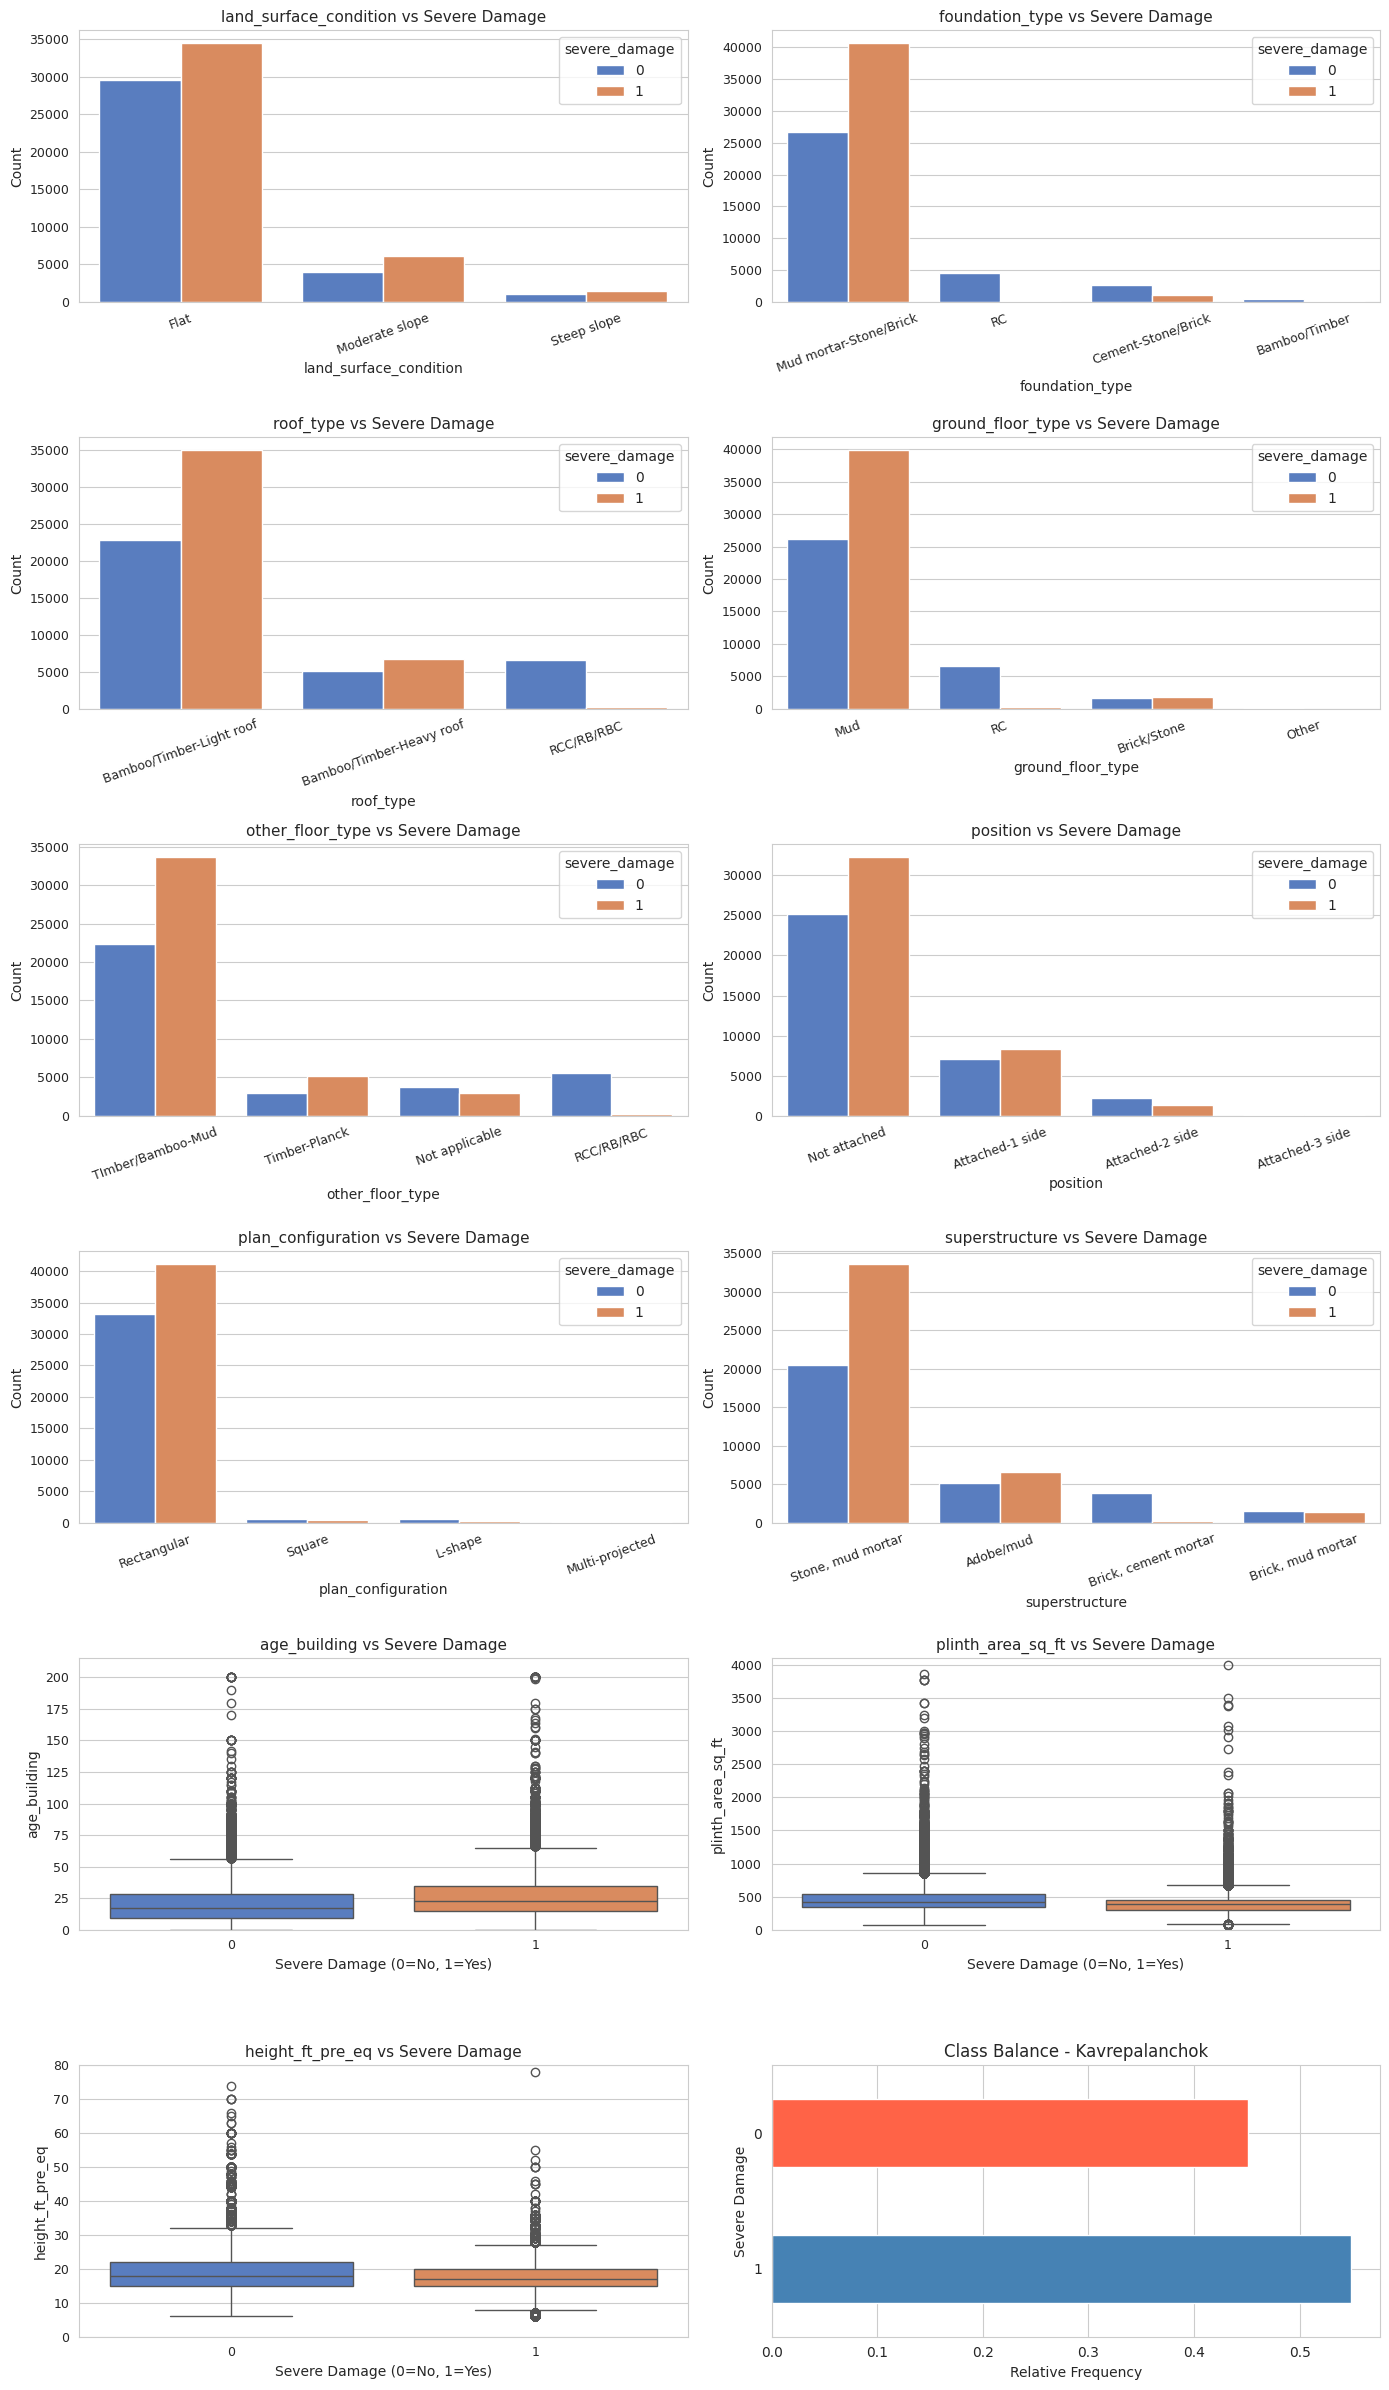

In [9]:
# Separating categorical and numeric features
categorical_cols = df_clean.select_dtypes(include="object").columns
numeric_cols = df_clean.select_dtypes(include="int64").drop("severe_damage", axis=1).columns
all_features = list(categorical_cols) + list(numeric_cols)

# ====================================== EDA PLOTS ============================================

# Creating one huge plot of subplots to make the charts compact for readability in one image
fig, axes = plt.subplots(6, 2, figsize=(14, 24))  
axes = axes.flatten()

# Ploting Columns vs Severe Damage
for i, col in enumerate(all_features):
    ax = axes[i]
    if col in categorical_cols:
        # Keeps only first 4 categories for readability since 5,6 onwards contain little to no info
        top_cats = df_clean[col].value_counts().nlargest(4).index
        temp = df_clean[df_clean[col].isin(top_cats)]
        sns.countplot(data=temp, x=col, hue="severe_damage", palette="muted", ax=ax,
                      order=top_cats)
        ax.set_xlabel(col, fontsize=10)
        ax.set_ylabel("Count", fontsize=10)
        ax.tick_params(axis="x", rotation=20, labelsize=9)
        ax.tick_params(axis="y", labelsize=9)
    else:  # numeric cols
        sns.boxplot(data=df_clean, x="severe_damage", y=col, palette="muted", ax=ax)
        ax.set_xlabel("Severe Damage (0=No, 1=Yes)", fontsize=10)
        ax.set_ylabel(col, fontsize=10)
        ax.tick_params(axis="x", labelsize=9)
        ax.tick_params(axis="y", labelsize=9)
        
        # Limiting y-limits for each boxplots for readability
        if col == "age_building":
            ax.set_ylim(0, 215)
        elif col == "plinth_area_sq_ft":
            ax.set_ylim(0, 4100)
        elif col == "height_ft_pre_eq":
            ax.set_ylim(0, 80)
    ax.set_title(f"{col} vs Severe Damage", fontsize=11)

# Plotting distribution of Class 0 and 1 in severe_damage
ax_balance = axes[-1]
df_clean["severe_damage"].value_counts(normalize=True).plot(
    kind="barh", ax=ax_balance, color=["steelblue", "tomato"]
)
ax_balance.set_ylabel("Severe Damage")
ax_balance.set_xlabel("Relative Frequency")
ax_balance.set_title("Class Balance - Kavrepalanchok")


plt.tight_layout()
plt.show()

What above plots say: 
- Most buildings in Kavrepalanchok are in flat land surfaces (a few in moderate), have foundation_type as mud mortar-Stone/Brick, roof_type as Bamboo/Timber-Light roof, ground_floor_type as mud or Timber/Bamboo-Mud, position as Not_attached, plan_configuration as Rectangular, superstructure as Stone, mud mortar, and that most of their ages are below ~70 years, height below ~30, and plinth area below ~700 square feet. 
- Buildings that experienced the most severe damage had the following characteristics: foundation_type was mud mortar-Stone/Brick,roof_type as Bamboo/Timber-Light roof, ground_floor_type as mud or Timber/Bamboo-Mud, position as Not_attached, plan_configuration as Rectangular, superstructure as Stone, mud mortar. 

Therefore, when creating models, we need to make sure the models prioritize features that are severe_damage-specific, rather than features that just descrbe the overall data. 

For example, a model will be less efficient if it prioritizes the `flat` label in land_surface_condition as a good predictor of severe damage. This is because the `flat` label describes most of the buildings in Kavrepalanchok, not just buildings with severe damage = 1. With that in mind, you can see why `roof_type`, `other_floor_type`,`superstructure` , and `position` can contain the best classification features as their labels are more spread out making each label significant. 

Buildings with reinforced concrete (RC, RCC/RB/RBC) or brick-and-cement mortar construction (appearing in `foundation_type`, `roof_type`, `superstructure`, or `other_floor_type`) fall completely in Class 0, indicating less severe damage. This suggests that a strong model will leverage these features to separate resilient buildings (Class 0) from those more prone to severe damage (Class 1)

Also, older buildings, above ~30 years of age are almore likely to be found in Class 1 than 0.Buildings above ~20 square feet in height are more likely to be in Class 0, same with buildings with plinth area above ~490 square feet. 

- The Class Balance bar plot at the end shows that there are more buildings in Class 1 (severe_damage = 1) than Class 0 (severe_damage = 0). Meaning, good models need to balance sensitivity to Class 0 and Class 1 in order to correctly identify buildings that won’t be severely damaged and those that will be. i.e. not prioritizing one Class too much at the expense of the other. 


Below is a correlation heatmap that shows how all the features are related to another. Intersections with high correlation are items that are better predictors when paired together. Therefore, a better model will be able to note the correlation and use it to make better classifications. 

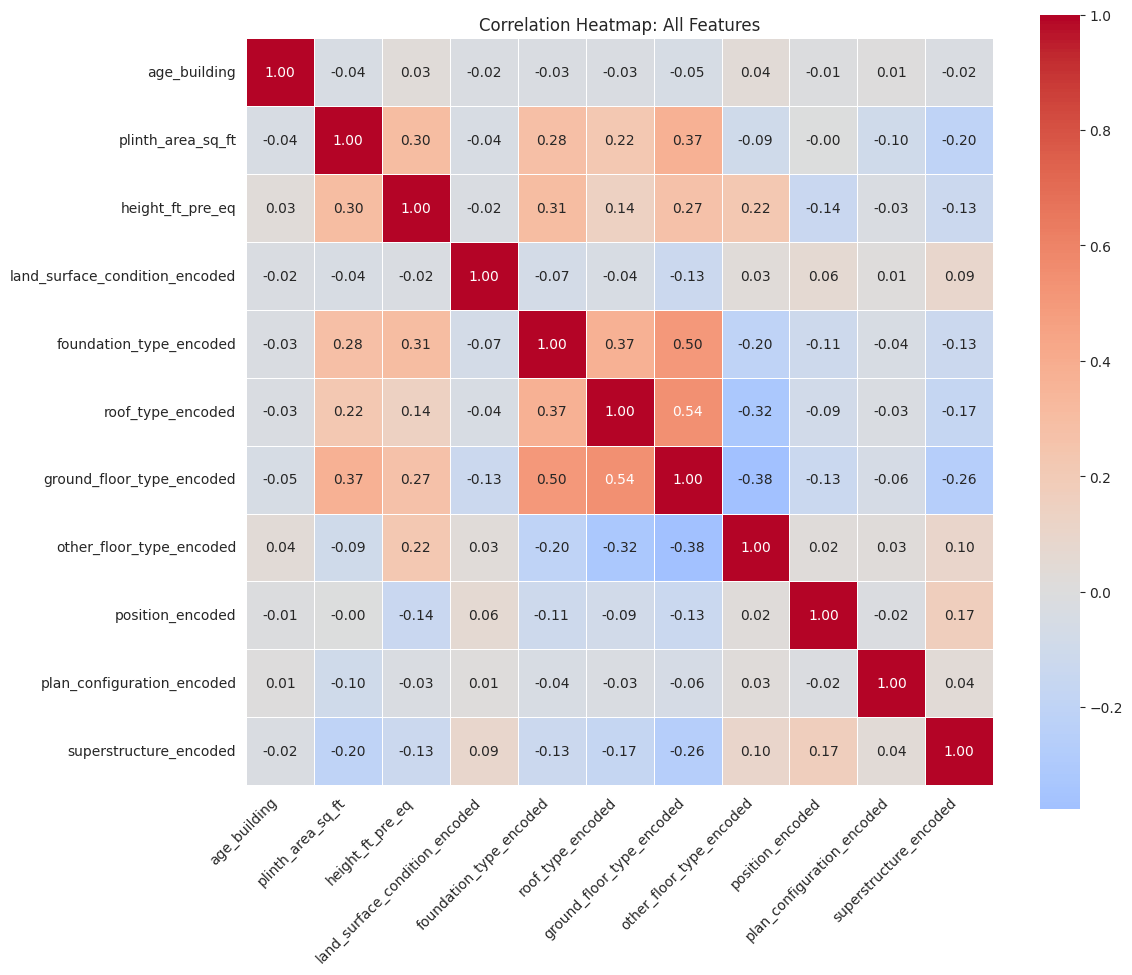

In [10]:
# Make a copy to avoid modifying original data
df_corr = df_clean.copy()

# Encode categorical variables
le = LabelEncoder()
categorical_cols = ['land_surface_condition', 'foundation_type', 'roof_type', 
                   'ground_floor_type', 'other_floor_type', 'position', 
                   'plan_configuration', 'superstructure']

for col in categorical_cols:
    df_corr[col + '_encoded'] = le.fit_transform(df_corr[col])


# Select all numerical columns (original numerical + encoded categorical)
numerical_cols = ['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq']
encoded_cols = [col + '_encoded' for col in categorical_cols]
all_numerical = numerical_cols + encoded_cols

# Calculate correlation matrix
correlation_matrix = df_corr[all_numerical].corr()



# Create the comprehensive heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm', 
            center=0,
            square=True,
            linewidths=0.5,
            fmt='.2f')  # Format to 2 decimal places

plt.title('Correlation Heatmap: All Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



# 030: Build 

Steps: 
1. Split - create feature matrix X and target vector y ("severe_damage").
2. Divide dataset into training and validation sets using randomized split (80-20 split).
3. Calculate baseline accuracy score for our models.
4. Create a Logistic Regression model and evaluate its performance metrics. 
5. Create a Decicion Tree model and evaluate its performance metrics. 
6. Create a Random Forest model and evaluate its performance metrics. 
7. Pick the best of the three models for further evaluation or deployment. 

In [11]:
# Split df_clean into feature matrix `X` and target vector `y` 

target = "severe_damage"
X = df_clean.drop(columns = target)
y = df_clean[target]
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (76533, 11)
y shape: (76533,)


In [12]:
# Using X and y, we divide them into training and validation sets using a randomized split. 
# Validation set should be 20% of the total data.

X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size = 0.2, random_state = 42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (61226, 11)
y_train shape: (61226,)
X_val shape: (15307, 11)
y_val shape: (15307,)


In [13]:
# Baseline - calculating baseline accuracy score for our models 

acc_baseline = y_train.value_counts(normalize = True)[1]
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


## 031: Logistic Regression Model 


Steps: 
- Define the parameter grid with a range of hyperparameters 
- Create the Logistic Regression model pipeline 
- Use GridSearchCV to incorporate the hyperparamaters into the model pipeline and cross-validate wrt to 'recall' scoring
- Train the model on the training data to find the best Logistic Regression model, best parameters, and cross validation results of all trained models 
- Extract the best trained model and use it to get predictions on training data and validation data 
- Print the performance metrics and classification report for evaluation 

In [14]:
# Logistic regression hyperparameter tuning with GridSearch 

# Define the parameter grid for hyperparameter tuning: 
#     C-strength of regularization, penalty-regularization type, solver-algorithm with needed math for optimization

lr_param_grid = {
    "logisticregression__C": [0.01, 0.1, 1, 10],
    "logisticregression__penalty": ["l1", "l2"],
    "logisticregression__solver": ["liblinear"]  
}

# lr_model - the pipeline of the model, not the  trained model yet

lr_model = make_pipeline(                                        
    OneHotEncoder(use_cat_names=True),                           # turns categorical variables into numeric 0/1 (ML models can’t handle text directly)
    LogisticRegression(max_iter=2000, random_state=42)           # LogisticRegression-the algorithm (classifier-an algorithm that outputs classes instead of continuous values)
)

# GridSearchCV tries every combo in param_grid i.e. 4 values of C × 2 penalties × 1 solver = 8 experiments 
# lr_grid is the variable storing the GridSearchCV object (containing lr_model pipeline, params, and cv settings)

lr_grid = GridSearchCV(                                           
    lr_model,
    lr_param_grid,
    cv=5,
    scoring="recall",                                            
    n_jobs=-1
)

# Below code uses lr_grid to fit every combo onto training data. Evaluates the combos, keeps the results, and stores the best model. 
# It holds the GridSearchCV object after training (containing best model, best params, and cv results of every model combo tried
#                                                           - all accessble via .best_estimator_, .best_params_, .cv_results_) 


lr_grid.fit(X_train, y_train)                                      

print("\n=== Logistic Regression ===")
print("Best Params:", lr_grid.best_params_)   


# best_lr - is the trained model we are looking for, accessed from lr_grid by .best_estimator_

best_lr = lr_grid.best_estimator_                                   


# Making predictions with the best_lr model on both training and validation sets

lr_y_train_preds = best_lr.predict(X_train)  
lr_y_val_preds = best_lr.predict(X_val) 

# Performance Metrics - take the above predictions and compare them to the true values y_train and y_val
#      If both scores are close, the model generalizes well. But, if training scores are much higher, then it is overfitting.

print("\n=== Training Set Metrics (Positive Class = severe_damage = 1)===")
print(f"Accuracy: {accuracy_score(y_train, lr_y_train_preds):.4f}")
print(f"Recall:   {recall_score(y_train, lr_y_train_preds):.4f}")
print(f"Precision:{precision_score(y_train, lr_y_train_preds):.4f}")
print(f"F1:       {f1_score(y_train, lr_y_train_preds):.4f}")

print("\n=== Validation Set Metrics (Positive Class = severe_damage = 1) ===")
print(f"Accuracy: {accuracy_score(y_val, lr_y_val_preds):.4f}")
print(f"Recall:   {recall_score(y_val, lr_y_val_preds):.4f}")
print(f"Precision:{precision_score(y_val, lr_y_val_preds):.4f}")
print(f"F1:       {f1_score(y_val, lr_y_val_preds):.4f}")

# Validation metrics - this is what matters: how well the model performs on unseen data.

print("Classification Report from Validation Set (X_val, y_val):")
print(classification_report(y_val, lr_y_val_preds, digits=4))



=== Logistic Regression ===
Best Params: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}

=== Training Set Metrics (Positive Class = severe_damage = 1)===
Accuracy: 0.6516
Recall:   0.9355
Precision:0.6208
F1:       0.7463

=== Validation Set Metrics (Positive Class = severe_damage = 1) ===
Accuracy: 0.6530
Recall:   0.9342
Precision:0.6241
F1:       0.7483
Classification Report from Validation Set (X_val, y_val):
              precision    recall  f1-score   support

           0     0.7907    0.3063    0.4415      6856
           1     0.6241    0.9342    0.7483      8451

    accuracy                         0.6530     15307
   macro avg     0.7074    0.6203    0.5949     15307
weighted avg     0.6987    0.6530    0.6109     15307



**Explanations:**

I used `scoring="recall"` in GridSearchCV so that the search would pick parameters that maximized recall during cross-validation, not accuracy.

Recall - measures a model's ability to find all actual positive cases (`severe_damage` = 1), making it crucial for disaster preparedness, where failing to detect an event is more dangerous than an unnecessary alarm. In earthquake classification problems, Recall is the most important metric over precision, accuracy, and the F1 score because missing a real earthquake (a false negative) can have catastrophic consequences, outweighing the impact of false alarms (false positives). [More on classification metrics -> developers.google](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall#:~:text=The%20F1%20score%20is%20the,average%20of%20precision%20and%20recall.&text=This%20metric%20balances%20the%20importance,a%20perfect%20score%20of%201.0.)

All the metrics (recall, precision, F1) are being calculated with `severe_damage = 1` as the positive class / "True Positive" focus. For more details on 0, look at the classification report. 

**Conclusion**

- Recall = 0.9342 (very high): The model catches most of the severe_damage = 1 cases. i.e, it is tuned toward safety/recall. This is a great score as real-world scenarios require at least 0.90+. 
- Precision = 0.6241 (moderate): Out of all buildings predicted as “severely damaged,” only about 62% actually are. That means we have more false alarms than is necessary. The next goal is to increase this to about 0.70 - 0.90 to avoid drowning in false alarms. 
- Accuracy = 0.6530 (low): This is expected given that accuracy gets dragged down when the model prioritizes recall over precision. Anything between 0.65–0.80 is realistic if recall is prioritized.
- F1 = 0.7483 (good): This shows the model is decent at balancing recall and precision, but not perfect. F1 is the harmonic mean of precision and recall, therefore a healthy zone of 0.75–0.85 is great, showing the model is not sacrificing one metric completely for the other.

*Note the Class imbalance effect*: From the classification report, Class 0 (Grade 1 - 3) has poor recall (0.3063), while class 1 (Grade 4 - 5) has very high recall (0.9342). This means that the model is heavily biased toward catching positives, almost at the expense of negatives. 

With this in mind, the conclusion is that this Logistic Regression model is highly effective at detecting severely damaged buildings (recall = 0.9342), making it useful in situations where false negatives are unacceptable. However, its overall accuracy (0.6530) and precision (0.6241) suggest many false positives, meaning the model is over-flagging damage. This trade-off is typical of models optimized for recall. To see if we can improve both accuracy and precision without sacrificing too much recall, it makes sense to try more flexible models like Decision Trees and Random Forest.


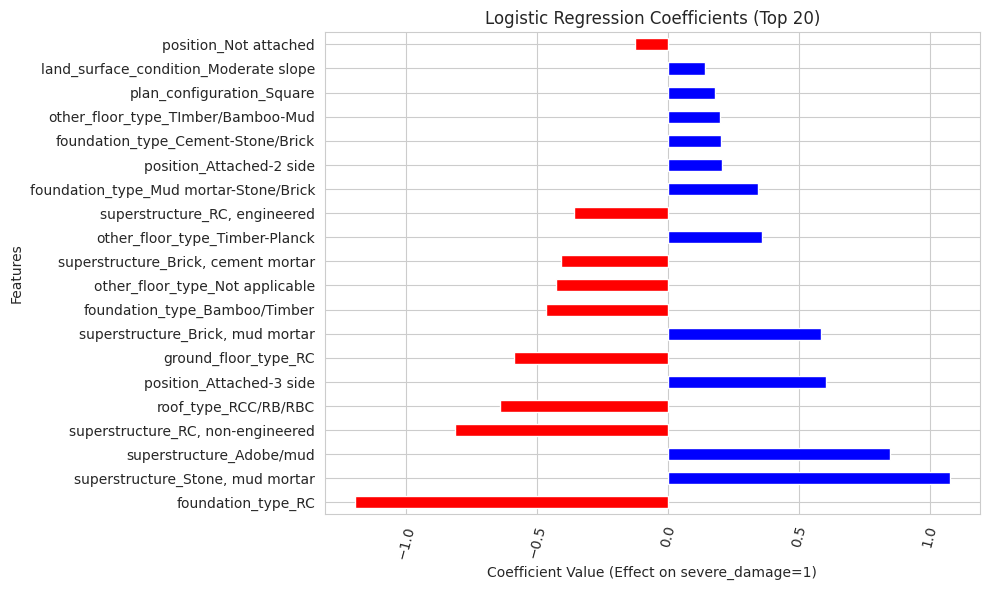

In [15]:
# === Feature Importance (Coefficients) for Logistic Regression ===
# 
# Extract the fitted OneHotEncoder and LogisticRegression from the pipeline
lr_ohe = best_lr.named_steps['onehotencoder']
lr_clf = best_lr.named_steps['logisticregression']

# Get feature names
feature_names = lr_ohe.get_feature_names_out(X_train.columns)

# Get coefficients for the positive class (class 1)
lr_coefs = pd.Series(lr_clf.coef_[0], index=feature_names)

# Sort by absolute value (magnitude of effect)
coefs_sorted = lr_coefs.reindex(lr_coefs.abs().sort_values(ascending=False).index)

# Plot top 20 most influential features
plt.figure(figsize=(10,6))
coefs_sorted.head(20).plot(kind="barh", color=['red' if c < 0 else 'blue' for c in coefs_sorted.head(20)])
plt.title("Logistic Regression Coefficients (Top 20)")
plt.xlabel("Coefficient Value (Effect on severe_damage=1)")
plt.ylabel("Features")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()

**Logistic Regression Model's Feature Importance Interpretation:**

The feature importance is exactly what we would expect from a structural engineering point of view: buildings with reinforced (RC) designs shield against destruction, while traditional mud-based or poorly bonded masonry buildings are dangerously fragile and more likely to experience severe damage during an earthquake. 

- Blue bars show features that increase probability of severe damage. Therefore, features like like superstructure_Stone, mud mortar, Adobe/mud, or Brick, mud mortar, position_Attached-3 side & _Attached-2 side, floor_type_Timber-Planck,  play bigger roles in increasing likelihood of severe damage.

- Red bars show features that decrease probability of severe damage. Therefore, features like foundation_type_RC, roof_type_RCC/RB/RBC, and superstructure_RC, engineered, foundation_type_Bamboo/Timber, and ground_floor_type_RC play bigger roles in ensuring buildings DO NOT experience severe damage.  


Note that the LR model aligns with MOST of what was observed in the EDA stage:

- that buildings with reinforced concrete (RC, RCC/RB/RBC) are the biggest predictors of whether a building is in Class 0 or 1. And the LR uses this to basically draw a line between the classes, which explains why foundation_type_RC and superstructure_Stone-mud-mortar are the top predictors as these are labels belonging to only Class 0, helping draw a firmer line. 
- In EDA, class distinctions were clearer in a few columns (`roof_type`, `other_floor_type`,`superstructure`, `position`) across several labels. Hence, why LR used them as they helped differentiate the classes more. 

LR fails to align with some of the EDA findings like the influence of `age_building`, `height_ft_pre_eq` and `plinth_area_sq_ft`. This is because LR models struggle with finding importance of numerical values unless they are standardized beforehand or  

Also, older buildings, above ~30 years of age are almore likely to be found in Class 1 than 0.Buildings above ~20 square feet in height are more likely to be in Class 0, same with buildings with plinth area above ~490 square feet. 

All in all, the LR model uses a linear method to differentiate the classes and gets the job done. However, it is clear how it is doing this which makes for easier interpretability but not for great classification when you require more nuanced details to be captured.

The Decision Tree model is used below to try and capture more granular details while classifying. 

## 032: Decision Tree Model 

Steps: 
- Define the parameter grid with a range of hyperparameters 
- Create the Decision Tree model pipeline 
- Use GridSearchCV to incorporate the hyperparamaters into the model pipeline and cross-validate wrt to 'recall' scoring
- Train the model on the training data to find the best Decision Tree model, best parameters, and cross validation results of all trained models 
- Extract the best trained model and use it to get predictions on training data and validation data 
- Print the performance metrics and classification report for evaluation 

In [16]:
# Parameter grid for Decision Tree

dt_param_grid = {
    "decisiontreeclassifier__max_depth": [3, 5, 10, None],       # controls tree depth to prevent overfitting
    "decisiontreeclassifier__min_samples_split": [2, 5, 10],     # controls node splitting
    "decisiontreeclassifier__min_samples_leaf": [1, 5, 10],      # avoids tiny, overfitted leaves
}

# dt_model pipeline

dt_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),        # same encoder for 
    DecisionTreeClassifier(random_state=42)
)

# GridSearchCV
dt_grid = GridSearchCV(
    dt_model,
    dt_param_grid,
    cv=5,
    scoring="recall",   # use "accuracy" to experiment and see difference in results
    n_jobs=-1
)

# Fit on the training data to find the best model, best parameters, and CV results of all trained models
dt_grid.fit(X_train, y_train)

print("\n=== Decision Tree ===")
print("Best Params:", dt_grid.best_params_)

# Extract best trained model
best_dt = dt_grid.best_estimator_

# Predictions
dt_y_train_preds = best_dt.predict(X_train)
dt_y_val_preds   = best_dt.predict(X_val)

# Metrics
print("\n=== Training Set Metrics (Positive Class = severe_damage = 1) ===")
print(f"Accuracy: {accuracy_score(y_train, dt_y_train_preds):.4f}")
print(f"Recall:   {recall_score(y_train, dt_y_train_preds):.4f}")
print(f"Precision:{precision_score(y_train, dt_y_train_preds):.4f}")
print(f"F1:       {f1_score(y_train, dt_y_train_preds):.4f}")

print("\n=== Validation Set Metrics (Positive Class = severe_damage = 1) ===")
print(f"Accuracy: {accuracy_score(y_val, dt_y_val_preds):.4f}")
print(f"Recall:   {recall_score(y_val, dt_y_val_preds):.4f}")
print(f"Precision:{precision_score(y_val, dt_y_val_preds):.4f}")
print(f"F1:       {f1_score(y_val, dt_y_val_preds):.4f}")

print("\nClassification Report from Validation Set (X_val, y_val):")
print(classification_report(y_val, dt_y_val_preds, digits=4))



=== Decision Tree ===
Best Params: {'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2}

=== Training Set Metrics (Positive Class = severe_damage = 1) ===
Accuracy: 0.6389
Recall:   0.9835
Precision:0.6048
F1:       0.7490

=== Validation Set Metrics (Positive Class = severe_damage = 1) ===
Accuracy: 0.6441
Recall:   0.9856
Precision:0.6100
F1:       0.7536

Classification Report from Validation Set (X_val, y_val):
              precision    recall  f1-score   support

           0     0.9262    0.2233    0.3599      6856
           1     0.6100    0.9856    0.7536      8451

    accuracy                         0.6441     15307
   macro avg     0.7681    0.6044    0.5567     15307
weighted avg     0.7516    0.6441    0.5772     15307



**Explanation** 

- Recall = 0.9856 (extremely high): The tree is even more aggressive than logistic regression at catching severely damaged buildings. It almost never misses a severe_damage = 1. This is excellent for safety-critical contexts.
- Precision = 0.6100 (moderate/low): Slightly worse than logistic regression. Out of all the “severe” predictions, nearly 40% are false alarms. That’s still a lot of over-flagging.
- Accuracy = 0.6441 (low): Very similar to logistic regression (0.6530). As expected, prioritizing recall drags accuracy down because negatives (0s) are often misclassified.
- F1 = 0.7536 (good):Marginally better than logistic regression’s F1. It balances recall and precision a tiny bit better - but recall is so high that it masks precision’s weakness.

Note that the Class imbalance effect is even high here than logistic regression. Class 0 recall = 0.2233 (!), meaning less-damaged buildings are almost always misclassified. Meaning, the Decision Tree is more paranoid. 

The choice between the two boils down to if you want absolute safety in which case the Decision Tree wins. Also, if practical deployment is the priority (high recall but not drowning in false alarms), Logistic Regression is the better baseline.

I used scoring="accuracy" to experiment and see difference in results. The results were Recall (0.8582), F1 Score (0.7372), Precision (0.6460), and Accuracy (0.6621). Class 0 recall = 0.4204 which is an improvement because accuracy focus forced the model to reduce false alarms.

Even though accuracy scoring gave a small boost in overall accuracy and Class 0 recall, it came at the cost of missing more severely damaged buildings (Class 1 recall fell from ~0.98 to ~0.86). In earthquake risk classification, this trade-off is not acceptable -  because a false negative means failing to identify a dangerous structure. Therefore, recall is the more appropriate metric to optimize, even if it hurts accuracy and Class 0 performance.



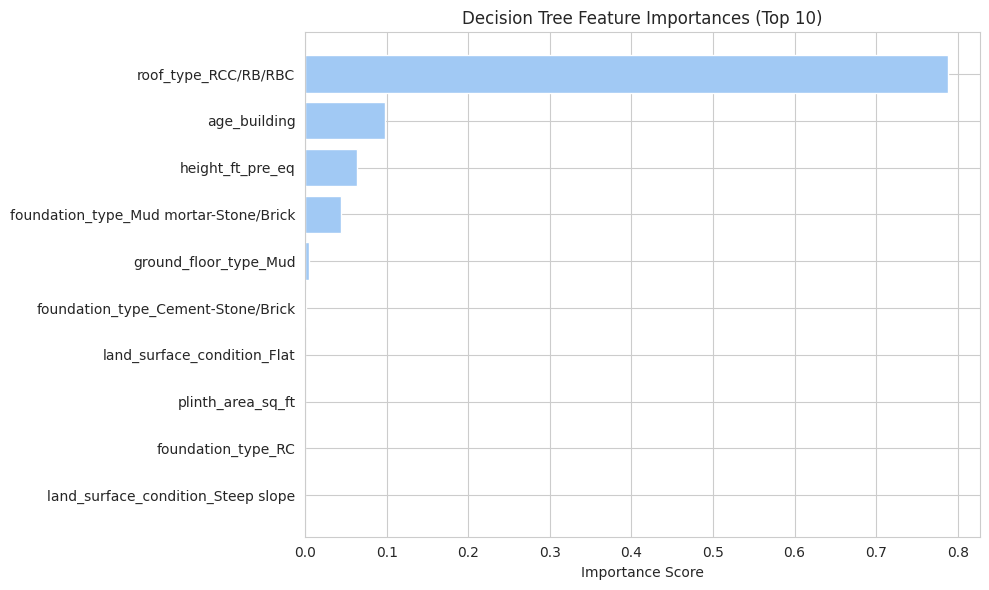

In [45]:
# === Feature Importance Visualization for Decision Tree ===

# Extract the fitted OneHotEncoder and DecisionTree from the pipeline
dt_ohe = best_dt.named_steps['onehotencoder']
dt_clf = best_dt.named_steps['decisiontreeclassifier']

# Get feature names from encoder
dt_feature_names = dt_ohe.get_feature_names_out(X_train.columns)


# # Pair features with importance scores in a DataFrame
# dt_feat_imp_df = pd.DataFrame({
#     "Feature": dt_feature_names,
#     "Importance": dt_clf.feature_importances_
# }).sort_values(by="Importance", ascending=False)

# # Print features
# print(dt_feat_imp_df.head(10))

# Plot 
plt.figure(figsize=(10, 6))
plt.barh(dt_feat_imp_df["Feature"].head(10), dt_feat_imp_df["Importance"].head(10))
plt.title("Decision Tree Feature Importances (Top 10)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()  # highest at top
plt.tight_layout()
plt.show()

**Decision Tree Model's Feature Importance (non-zero importances) Interpretation - DT**


Here, reinforced concrete buildings are still the biggest predictors. We have two numerical columns that were absent in the LR model feature importance because LR models aren't the best at classifying using continuous variables. 

- roof_type_RCC/RB/RBC (~0.79) - Nearly 80% of the model’s decision power comes from whether the roof is reinforced concrete (RCC/RB/RBC). Basically, to the DT model, `roof_type` is the most important feature of predicting if a building will experience severe damage. Note that `roof_type_RCC/RB/RBC` was also top 3 in LR's feature importance chart but below `foundation_type` and `superstructure` column features.

- age_building (almost 0.10) - This makes sense, older buildings are often more fragile. Note that LR model didnt include `age_building` in its top 20. This is because DT models are able to incorporate more continuous variables into the model by comparing their relationship to categorical variables. LR models can't do this as they are linear in classifying data. 

- height_ft_pre_eq (~0.06) - Taller buildings = more stress during quakes. This also aligns with what we saw with the `df_clean` characteritics in the EDA phase.  

- foundation_type_Mud mortar-Stone/Brick (~0.04) - A smaller but still relevant importance. Essentially, weak traditional foundations are risky.
- ground_floor_type_Mud - Barely there.

Everything else is ignored by the Decision Tree. This may seem like a problem because comparing this to the Logistic Regression (LR), we see that LR spread attention across many features but DT only focused on five features, with most focus on roof_type_RCC/RB/RBC alone. 

However, it is important to note that Decision Trees work differently by spliting non-linear patterns, automatically considering interactions (as seen in corr heatmap in EDA) and buidling a one big tree based on complex relationships. Essentially, DT picks the single strongest feature at each split to associate all the other features to and this happens to be roof_type_RCC/RB/RBC. All the other features are indirectly included. 

**Decision Tree improves on the Recall Score, but still sacrifices a lot of false positives**

Overall, the Decision Tree is doing the intended job but we need to find a model that has better balancing. This shows that the dataset has limited signal for decision trees alone - we've hit the ceiling for a single tree. 

For earthquake damage prediction, ensembles (Random Forests, Gradient Boosting, XGBoost/LightGBM) usually lift performance well because they combine many weak trees into a stronger predictor.

## 033: Random Forest Model 

The choice between Random Forests, Gradient Boosting, and XGBoost/LightGBM landed on Random Forest because its a natural succession to the Decision Tree. 

A Random Forest is essentially an ensemble of hundreds of trees, each trained on:
- A bootstrap sample of the data (row sampling).
- A random subset of features (column sampling) for each split.

This “randomness” forces the model to spread attention across more features, thereby achieving a more balanced model than a Decision Tree. 


Steps: 

- Defining the range of hyperparameters
- Creating the Random Forest model pipeline with OneHotEncoder and a RandomForestClassifier. The pipeline ensures preprocessing and model fitting are tied together
- Using RandomizedSearchCV to incorporate hyperparameters into the model pipeline and cross-validating with respect to 'recall' scoring
- Training the model on the training data to find the best Random Forest model, best parameters, and cross-validation results of all sampled models
- Extracting the best trained model and using it to get predictions on training data and validation data
- Printing the performance metrics and classification report for evaluation

In [ ]:
# === Random Forest Model ===

# Hyperparameters 
rf_param_dist = {
    "randomforestclassifier__n_estimators": [100, 150, 200],      # keep it tight
    "randomforestclassifier__max_depth": [10, 20, None],          # shallow vs. deep
    "randomforestclassifier__min_samples_split": [2, 5],          # smaller search
    "randomforestclassifier__min_samples_leaf": [1, 2],           # avoid tiny leaves
    "randomforestclassifier__class_weight": ["balanced"]          # keep recall healthy
}

# Pipeline
rf_model = make_pipeline(
    OneHotEncoder(handle_unknown="ignore"),
    RandomForestClassifier(random_state=42, n_jobs=-1)
)

# Randomized search
rf_search = RandomizedSearchCV(
    rf_model,
    rf_param_dist,
    n_iter=10,            # sample just 10 combos
    cv=5,                 # fewer folds = faster (can use 3 instead of 5)
    scoring="recall",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Fit
rf_search.fit(X_train, y_train)

print("\n=== Random Forest (Fast Search) ===")
print("Best Params:", rf_search.best_params_)

# Best model
best_rf = rf_search.best_estimator_

# Predictions
rf_y_train_preds = best_rf.predict(X_train)
rf_y_val_preds   = best_rf.predict(X_val)

# Metrics
print("\n=== Training Set Metrics ===")
print(f"Accuracy: {accuracy_score(y_train, rf_y_train_preds):.4f}")
print(f"Recall:   {recall_score(y_train, rf_y_train_preds):.4f}")
print(f"Precision:{precision_score(y_train, rf_y_train_preds):.4f}")
print(f"F1:       {f1_score(y_train, rf_y_train_preds):.4f}")

print("\n=== Validation Set Metrics ===")
print(f"Accuracy: {accuracy_score(y_val, rf_y_val_preds):.4f}")
print(f"Recall:   {recall_score(y_val, rf_y_val_preds):.4f}")
print(f"Precision:{precision_score(y_val, rf_y_val_preds):.4f}")
print(f"F1:       {f1_score(y_val, rf_y_val_preds):.4f}")

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, rf_y_val_preds, digits=4))



Fitting 5 folds for each of 10 candidates, totalling 50 fits



=== Random Forest (Fast Search) ===
Best Params: {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__class_weight': 'balanced'}

=== Training Set Metrics ===
Accuracy: 0.6527
Recall:   0.9686
Precision:0.6165
F1:       0.7534

=== Validation Set Metrics ===
Accuracy: 0.6549
Recall:   0.9677
Precision:0.6202
F1:       0.7559

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0     0.8712    0.2694    0.4115      6856
           1     0.6202    0.9677    0.7559      8451

    accuracy                         0.6549     15307
   macro avg     0.7457    0.6185    0.5837     15307
weighted avg     0.7326    0.6549    0.6017     15307



**Explanation**

If you want a model that avoids over-predicting positives while keeping good recall, Random Forest is the answer between the three.

- Recall () -  
- Precision () - 
- F1 Score ()- 
- Accuracy () - 

Overall, Random Forest is 

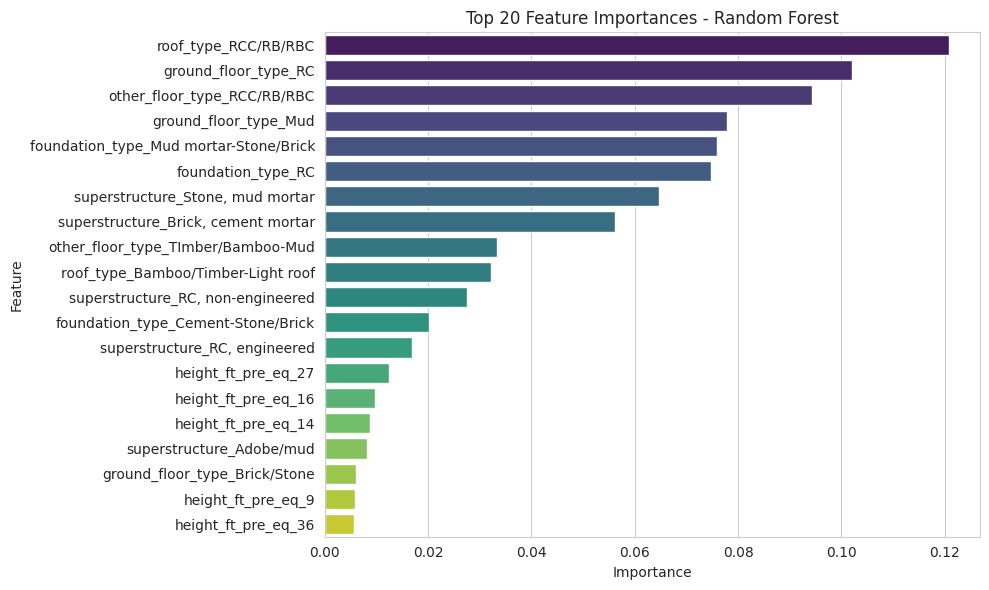

In [46]:
# === Feature Importance Visualization for the Random Forest Model ===


# Extract classifier and encoder from pipeline
rf_clf = best_rf.named_steps['randomforestclassifier']
rf_ohe = best_rf.named_steps['onehotencoder']

# Get feature names after OneHotEncoding
rf_feature_names = rf_ohe.get_feature_names_out()

# Get feature importances
rf_importances = rf_clf.feature_importances_

# Put into DataFrame for easier handling
rf_feat_imp_df = pd.DataFrame({
    "Feature": rf_feature_names,
    "Importance": rf_importances
}).sort_values(by="Importance", ascending=False)

# # Print top features
# print(feat_imp_df.head(20))

# Plot 
plt.figure(figsize=(10, 6))
sns.barplot(
    data= rf_feat_imp_df.head(20),
    x="Importance", y="Feature",
    palette="viridis"
)
plt.title("Top 20 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

**Random Forest Feature Importance Interpretation**

All the features used are consistent with what the Decision Tree and Logistic Regression models. Here, the importances are more spread out than DT because Random Forest uses many ensemble trees in building rather than relying on one big feature to link everything. 

Essentially, Random Forest avoids overfitting by making sure no single feature always dominates like we saw in DT. 

**Final Verdict:**

If the goal is **practical, real-world prediction**, the Random Forest is the clear winner over a single Decision Tree. A Decision Tree tends to lock onto one or two dominant features (like roof type) and make almost all of its decisions from them. That makes it simple to interpret, but it also makes the model brittle - if that feature is missing, noisy, or less predictive in a new dataset, performance can drop sharply. Random Forests avoid this trap by combining the decisions of many trees, each trained on different subsets of data and features. This “wisdom of the crowd” effect balances out biases, reduces overfitting, and gives a more stable picture of which features matter across varied building conditions.

The Random Forest provides consistently delivers better generalization, spreads importance across multiple building characteristics, and captures subtle interactions that a single tree might ignore. For earthquake damage prediction, where decisions may affect rebuilding strategies or disaster response, reliability matters more than simplicity. 

# 040: Evaluate 

Plots to show the performance of all three models, side by side for comparison. 

Steps: 

1. Classification Reports
2. Confusion Matrix 

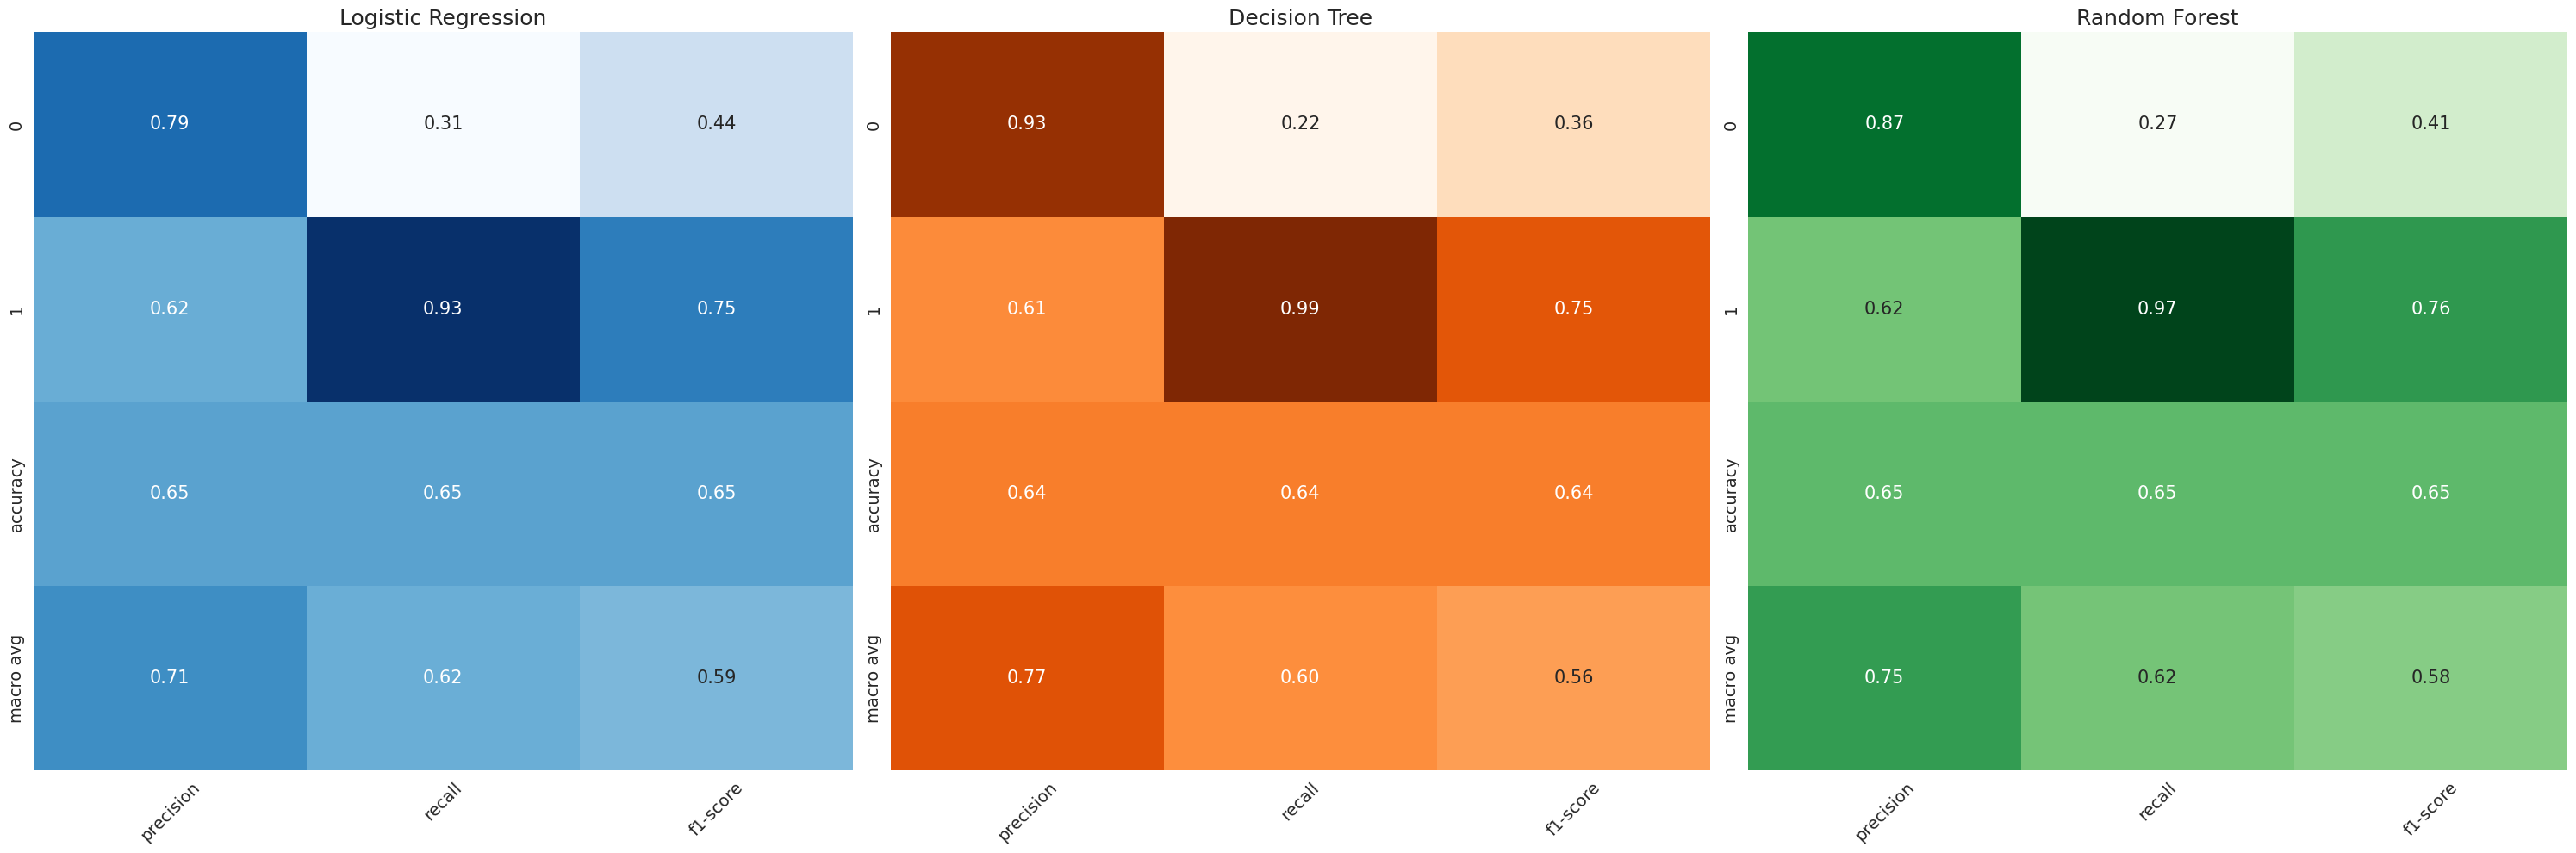

In [ ]:
# === Model Comparison - Classification Reports ===


# Generate classification reports as DataFrames

# --- Logistic Regression -- 
report_log = pd.DataFrame(classification_report(y_val, lr_y_val_preds, output_dict=True)).T

# --- Decision Tree -- 

report_dt = pd.DataFrame(classification_report(y_val, dt_y_val_preds, output_dict=True)).T

# --- Random Forest -- 

report_rf = pd.DataFrame(classification_report(y_val, rf_y_val_preds, output_dict=True)).T

# List of reports and titles
reports = [report_log, report_dt, report_rf]
titles = ["Logistic Regression", "Decision Tree", "Random Forest"]
cmaps = ["Blues", "Oranges", "Greens"]

# Side-by-Side Heatmaps 
fig, axes = plt.subplots(1, 3, figsize=(30, 10))
for i, (report, title, cmap) in enumerate(zip(reports, titles, cmaps)):
    # Exclude 'accuracy' row and 'support' column for heatmap
    sns.heatmap(
        report.iloc[:-1, :-1],  # all rows except 'accuracy', all columns except 'support'
        annot=True, fmt=".2f", cmap=cmap, ax=axes[i], cbar=False,
        annot_kws={"size": 15}
    )
    axes[i].set_title(title, fontsize=18)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].tick_params(axis='x', labelrotation=45, labelsize=14)
    axes[i].tick_params(axis='y', labelsize=14)

plt.tight_layout()

# # Save the report as an image, .png or .jog
# plt.savefig(
#     "/workspaces/Earthquake-Damage-Classification-Kavrepalanchok-Nepal/results/figures/Classification_Reports.png", 
#     dpi=600, bbox_inches="tight")


plt.show()

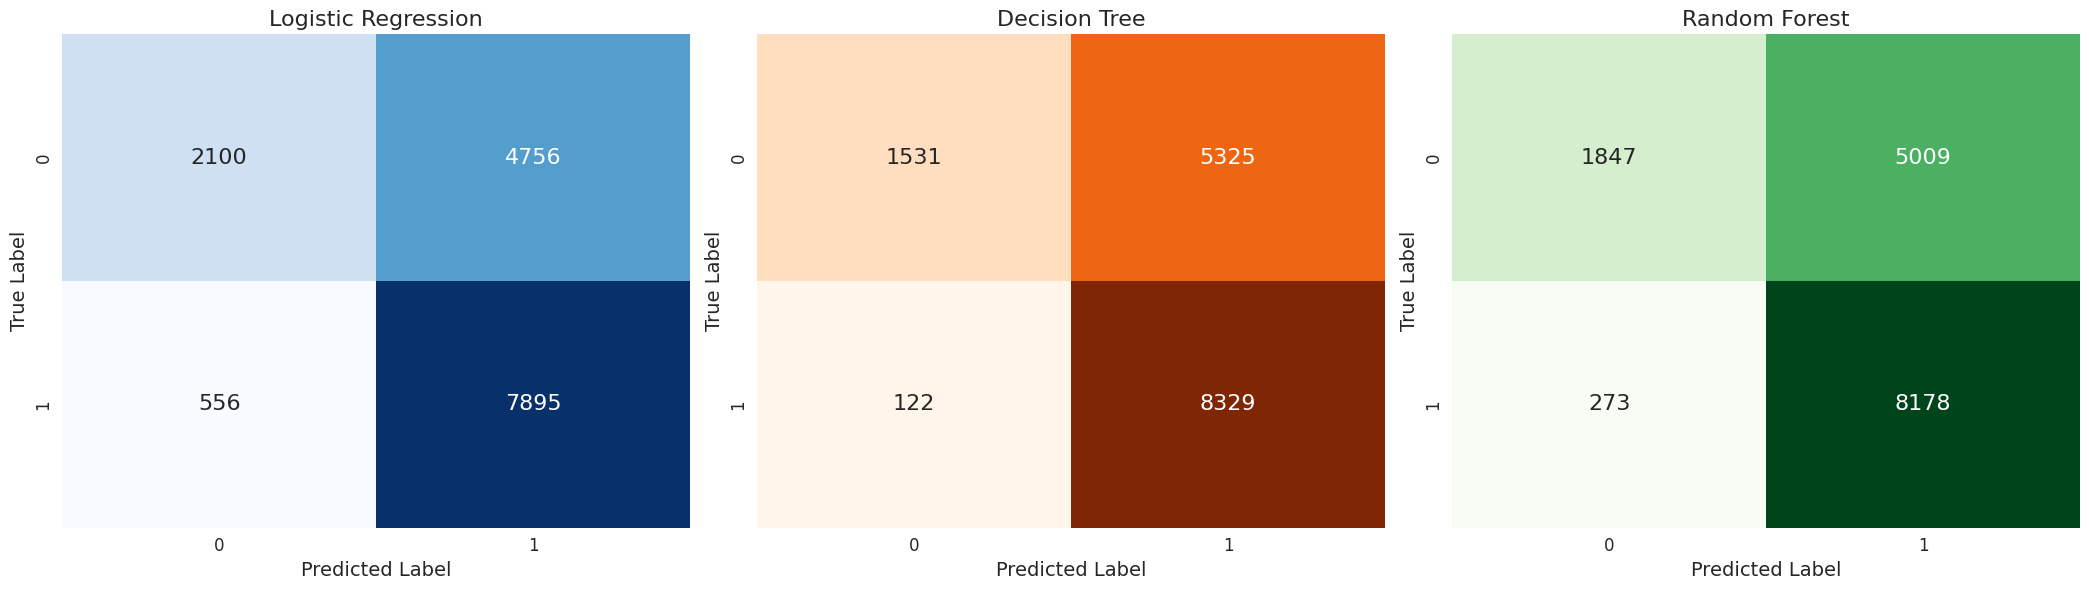

In [ ]:
# === Confusion Matrices ===


# Compute confusion matrices
cm_log = confusion_matrix(y_val, lr_y_val_preds)
cm_dt = confusion_matrix(y_val, dt_y_val_preds)
cm_rf = confusion_matrix(y_val, rf_y_val_preds)

# List of confusion matrices and titles
cms = [cm_log, cm_dt, cm_rf]
titles = ["Logistic Regression", "Decision Tree", "Random Forest"]
cmaps = ["Blues", "Oranges", "Greens"]

# Optionally, set class labels (e.g., [0, 1] for binary)
class_labels = [0, 1]

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 3, figsize=(21, 6))
for i, (cm, title, cmap) in enumerate(zip(cms, titles, cmaps)):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap,
        ax=axes[i],
        cbar=False,
        xticklabels=class_labels,
        yticklabels=class_labels,
        annot_kws={"size": 16}
    )
    axes[i].set_title(title, fontsize=16)
    axes[i].set_xlabel("Predicted Label", fontsize=14)
    axes[i].set_ylabel("True Label", fontsize=14)
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

plt.tight_layout()

# Save image 

# plt.savefig(
#     "/workspaces/Earthquake-Damage-Classification-Kavrepalanchok-Nepal/results/figures/Confusion_Matrices.png", 
#     dpi=300, bbox_inches="tight")

plt.show()

# 050: Communicate Results 

Steps: 
1. Model Performance Metrics Summary Bar Chart 
3. Plot Tree of Best Model, Random Forest 

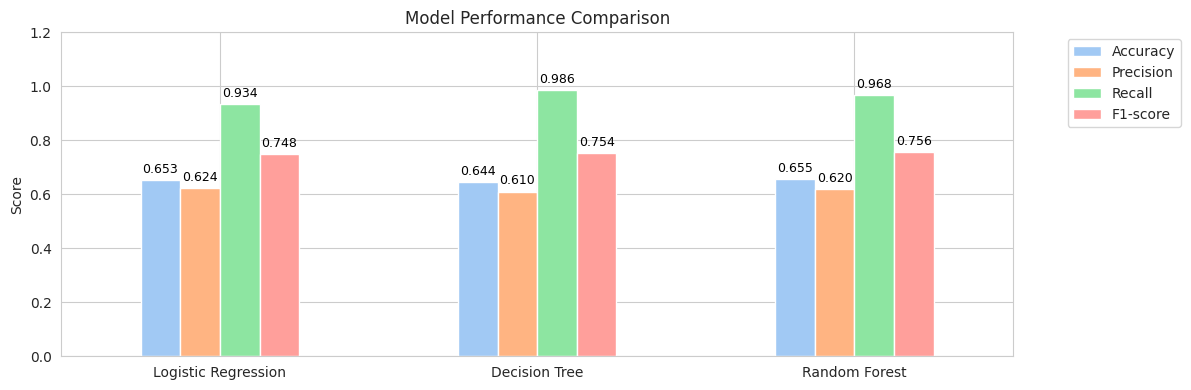

In [ ]:
# Model Performance Metrics Summary Table

model_metrics = {
    'Logistic Regression': {
        'Accuracy': accuracy_score(y_val, lr_y_val_preds),
        'Precision': precision_score(y_val, lr_y_val_preds),
        'Recall': recall_score(y_val, lr_y_val_preds),
        'F1-score': f1_score(y_val, lr_y_val_preds)
    },
    'Decision Tree': {
        'Accuracy': accuracy_score(y_val, dt_y_val_preds),
        'Precision': precision_score(y_val, dt_y_val_preds),
        'Recall': recall_score(y_val, dt_y_val_preds),
        'F1-score': f1_score(y_val, dt_y_val_preds)
    },
    'Random Forest': {
        'Accuracy': accuracy_score(y_val, rf_y_val_preds),
        'Precision': precision_score(y_val, rf_y_val_preds),
        'Recall': recall_score(y_val, rf_y_val_preds),
        'F1-score': f1_score(y_val, rf_y_val_preds)
    }
}

# DataFrame for easy comparison
summary_df = pd.DataFrame(model_metrics).T
# print(summary_df)

# Bar plot
ax = summary_df.plot(kind='bar', figsize=(12,4), rot=0)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.2)  
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Creating bars with values
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.3f}",   # format to 3 decimals
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='bottom',
        fontsize=9, color='black', rotation=0, xytext=(0, 3),
        textcoords='offset points'
    )

plt.tight_layout()

# Save Plot as Image 

# plt.savefig(
#     "/workspaces/Earthquake-Damage-Classification-Kavrepalanchok-Nepal/results/figures/Model_Performance_Comparison.png", 
#     dpi=600, bbox_inches="tight")


plt.show()

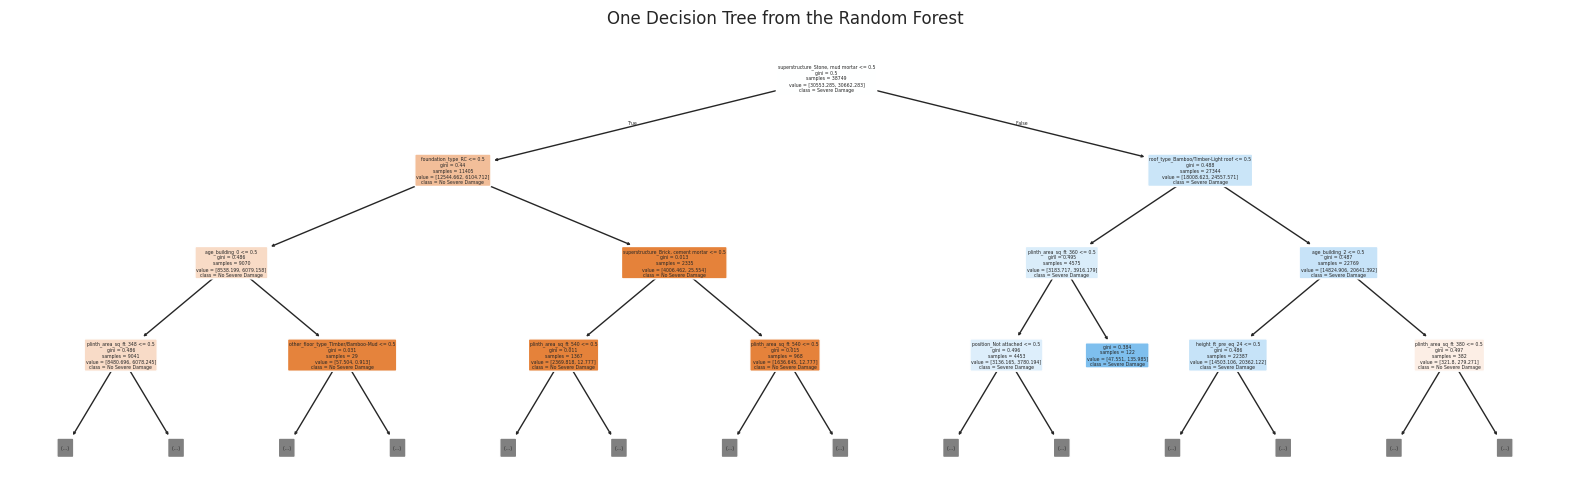

In [ ]:
# # === Plotting the first tree of the trained Random Forest model ===

# Extracting the RandomForestClassifier object from the pipeline
rf_clf = best_rf.named_steps['randomforestclassifier']

# Picking one tree from the forest (in this case, the first tree)
rf_estimator = rf_clf.estimators_[0]

# Plotting the tree
plt.figure(figsize=(20, 6))
plot_tree(rf_estimator, 
          max_depth =3, 
          filled=True, 
          rounded=True, 
          class_names=['No Severe Damage', 'Severe Damage'], 
          feature_names=best_rf.named_steps['onehotencoder'].get_feature_names_out())
plt.title("One Decision Tree from the Random Forest")

plt.show()

# Save Trained Models


Saving the Random Forest model for other uses. Including the Streamlit App (streamlit_app.py file) - to explore the Nepal earthquake data and use the best_rf model for predictions. 

In [ ]:
# Save the model to a text file, pkl file

import joblib

joblib.dump(best_rf, "/workspaces/Earthquake-Damage-Classification-Kavrepalanchok-Nepal/results/models/best_rf_model.pkl")
print("Model saved as best_rf_model.pkl")


Model saved as best_rf_model.pkl


In [72]:
X_test = pd.read_csv("/workspaces/Earthquake-Damage-Classification-Kavrepalanchok-Nepal/data/kavrepalanchok_test.csv")
X_test = X_test.drop(columns = "b_id")

X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9802 entries, 0 to 9801
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age_building            9802 non-null   int64 
 1   plinth_area_sq_ft       9802 non-null   int64 
 2   height_ft_pre_eq        9802 non-null   int64 
 3   land_surface_condition  9802 non-null   object
 4   foundation_type         9802 non-null   object
 5   roof_type               9802 non-null   object
 6   ground_floor_type       9802 non-null   object
 7   other_floor_type        9802 non-null   object
 8   position                9802 non-null   object
 9   plan_configuration      9802 non-null   object
 10  superstructure          9802 non-null   object
dtypes: int64(3), object(8)
memory usage: 842.5+ KB
